# <center>Denoising Autoencoder</center>

<p>In this experiment, we explore the concept of denoising autoencoders and their ability to learn hidden latent space representations. The goal is to train a denoising autoencoder using a synthetic dataset and evaluate its performance on a test dataset.</p>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import math

<h4>Dataset Generation</h4>

<p>We begin by generating a synthetic dataset comprising of latent points and their corresponding transformed values. The latent points are generated as random points on a circle, while the transformed values are calculated using a predefined transformation function. The dataset is then divided into a training set and a test set for model evaluation.</p>

<p>The process of generating the latent points involves selecting random angles between 0 and 2π, which determine the position of the points on the circle. The x and y coordinates of each point on the circle are calculated using trigonometric functions. These latent points represent the underlying structure of the data, which we aim to learn and reconstruct using the denoising autoencoder.</p>

<b>*It is worth noting that the choice of latent space points is crucial for visualizing the architecture of the denoising autoencoder. In this case, the hidden units in the autoencoder utilize the hyperbolic tangent (tanh) activation function. To effectively visualize the latent space, it is important to ensure that the values of the latent points fall within the range of -1 to 1. This range is suitable for the tanh activation function, as it allows the autoencoder to learn a latent space representation that best captures the underlying structure of the data.*</b>

<p>By generating the synthetic dataset and choosing the latent space points appropriately, we can provide the denoising autoencoder with a diverse range of input data for training and evaluation. This allows us to assess the model's ability to reconstruct the original latent points and capture the essential features of the data.</p>

In [2]:
def generate_dataset(n):
    set_latent = []
    set_x = []
    for i in range(n):
        angle = 2 * math.pi * torch.rand(1)  # Generate a random angle between 0 and 2*pi
        x = 0.7 * torch.cos(angle)  # Calculate x-coordinate of the point on the circle
        y = 0.7 * torch.sin(angle)  # Calculate y-coordinate of the point on the circle
        latent_point = torch.tensor([x, y])
        set_latent.append(latent_point)
        set_x.append(transform(latent_point))  # Assuming you have a transform function to convert latent points to input data
    return set_latent, set_x

def transform(x):
    y = torch.zeros(4)
    y[0] = torch.sin(x[0])
    y[1] = torch.cos(x[1])
    y[2] = torch.sum(x)
    y[3] = torch.sum(torch.exp(x))
    return y

In [3]:
_,x_train = generate_dataset(1000)
x_latent_test,x_test = generate_dataset(100)

<h4>Denoising Autoencoders vs. Autoencoders</h4>

<p>Autoencoders are neural network models that are designed to learn a compressed representation of input data. They consist of an encoder, which maps the input data to a lower-dimensional latent space, and a decoder, which reconstructs the original input data from the latent representation. Autoencoders are typically trained to minimize the reconstruction error between the input and the output.</p>

<p>While regular autoencoders can learn useful latent representations, they may also learn to encode noise present in the input data. This can lead to overfitting, where the autoencoder becomes overly sensitive to the specific noise patterns in the training data and fails to generalize well to new, unseen data. In such cases, the autoencoder may not capture the underlying structure or meaningful features of the data but instead memorize the noise.</p>

<p>To address this issue, denoising autoencoders were introduced. Denoising autoencoders are trained to reconstruct the original, clean input data from a corrupted version of the input. By deliberately corrupting the input with small amounts of noise, denoising autoencoders are forced to learn robust representations that capture the essential features of the data while ignoring the noise. This regularization technique helps prevent overfitting and encourages the autoencoder to learn more meaningful representations.</p>

<p>In the provided code, Gaussian noise with a standard deviation of 0.05 is added to the input data during training. The noise level is chosen to be neither too large nor too small, representing around 10% of the radius of the circle in the synthetic dataset. By training the denoising autoencoder with this corrupted input, we aim to improve its ability to extract the underlying structure and latent space representation of the data while disregarding the added noise.</p>

<p>The denoising autoencoder is then evaluated on the test dataset, where the performance is assessed by comparing the actual and predicted latent space values. This comparison allows us to observe whether the denoising autoencoder has successfully learned the hidden latent space representation and how well it generalizes to new, unseen data.</p>

<p>Overall, denoising autoencoders with small noise offer a regularization technique that helps improve the generalization and robustness of the learned representations, making them a useful tool for various applications, such as dimensionality reduction, feature extraction, and anomaly detection.</p>

In [4]:
class Denoising_Autoencoder(nn.Module):
    def __init__(self,input_size,hidden_size):
        super(Denoising_Autoencoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Tanh()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, input_size)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def train(self,x_train,learning_rate,max_epochs = 30):
        error_list = []
        # Training loop
        optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
        loss_function = nn.MSELoss()
        eps = 0
        for epoch in range(max_epochs):
            error = 0.0
            for x in x_train:
                # Add noise to the input data
                noisy_x = x + 0.05*torch.randn(self.input_size) #noise should be neither big nor small choose roung 10% of radius
                # Forward pass
                outputs = autoencoder(noisy_x)
                # Compute the loss
                reconstruction_loss = loss_function(outputs,x)
                error+= reconstruction_loss
                # Backward and optimize as it is stochastic gradient descent
                optimizer.zero_grad()
                reconstruction_loss.backward()
                optimizer.step()
            error_list.append(error.item()/len(x_train))
            eps +=1
            
        print("successfully completed training for ",eps," epochs")
        
        #plotting error
        xvals = np.arange(1,eps+1)
        plt.plot(xvals,error_list)
        plt.xlabel('Epoch')
        plt.ylabel('Mean Squared Error')
        plt.show()
        return error_list[-1]
        
    def test(self,x_test,x_latent_space):
        x_pred_latent = []
        loss_function = nn.MSELoss()
        error = 0.0
        for x in x_test:
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            x_pred_latent.append(encoded)
            error+= loss_function(decoded,x)
        error = (error/len(x_test))
        
        x_pred_latent  = torch.stack(x_pred_latent) #converts list of tensors to single vector of multi dimension
        x_latent_space = torch.stack(x_latent_space)
        
        # Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.
        x_pred_latent = x_pred_latent.detach().numpy()
        
        if(len(x_latent_space[0]) == 2):
            plt.scatter(x_latent_space[:,0],x_latent_space[:,1],label = "actual")

            plt.scatter(x_pred_latent[:,0],x_pred_latent[:,1],label = "predicted")
            plt.xlabel('x-axis')
            plt.ylabel('y-axis')
            plt.legend()
            plt.show()
        return error
        

successfully completed training for  30  epochs


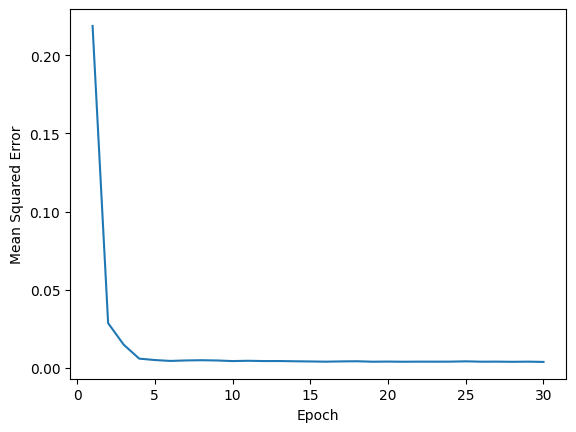

the training error is  0.003720324754714966


In [5]:
# Instantiate the denoising autoencoder
autoencoder = Denoising_Autoencoder(4,2)
print("the training error is ",autoencoder.train(x_train,0.007))

<h4>Testing</h4>

<p>After training the autoencoder, we evaluate its performance on the test dataset. The test dataset contains latent points and their corresponding transformed values. We compare the actual and predicted latent space values by encoding the test data and visualizing them.</p>

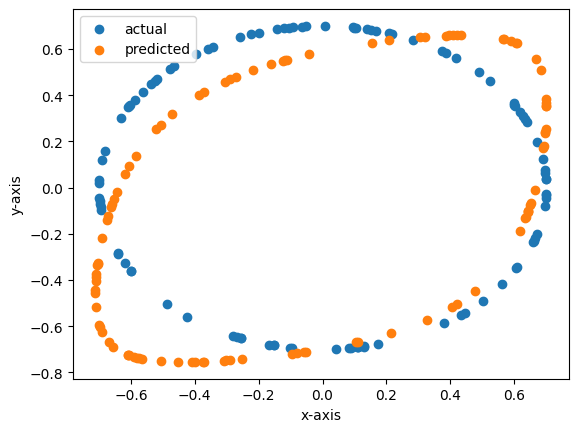

the error on the test dataset is  tensor(0.0043, grad_fn=<DivBackward0>)


In [6]:
error = autoencoder.test(x_test,x_latent_test)
print("the error on the test dataset is ",error)

<h4>Confusions and Interpretations</h4>

* Overlap: If the actual and predicted latent space values overlap significantly, it means the autoencoder has learned the underlying representation well and can reconstruct the original latent points accurately.
* Deviation/Dispersion: If the predicted latent space values deviate or have a larger dispersion compared to the actual values, it suggests that the autoencoder may not capture the complete information or complexities of the data.
* Misalignment/Clustering: If the predicted latent space values show misalignment or form distinct clusters different from the actual values, it indicates that the autoencoder may have learned different representaation than anticipated(also have to check test error) or failed to capture the true underlying structure of the data.
* High Test Error: If the error on the test dataset is high, it suggests that the denoising autoencoder may not effectively reconstruct the original latent points from the noisy inputs, indicating potential limitations in the model or data.

<p>Interpreting these confusions can provide insights into the autoencoder's performance and guide further improvements or investigations.</p>

# <center>Sparse Autoencoders</center>

In [7]:
import torchvision
import torchvision.transforms as transforms

# Define the transformation to apply to the MNIST data
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize the image pixel values to [-1, 1]
])

# Download and load the MNIST training set
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)


<h4>Model Architecture</h4>

<p>The Sparse Autoencoder is a neural network architecture designed to reconstruct input data while imposing a sparsity constraint on the hidden layer activations. It consists of an encoder and a decoder, where the encoder reduces the dimensionality of the input and produces a compressed representation in the hidden layer, while the decoder reconstructs the input from the hidden layer representation. By imposing sparsity, the autoencoder aims to learn a more concise and informative representation of the input data.</p>

<p>During training, the Sparse Autoencoder minimizes the mean squared error between the input and the reconstructed output. In addition to the reconstruction loss, the autoencoder also incorporates a sparsity regularization term using the Kullback-Leibler divergence loss. This sparsity regularization encourages the hidden layer activations to be sparse, meaning that only a few neurons are activated at a time. This constraint promotes a more efficient representation of the input, as it encourages the network to focus on the most important features and ignore irrelevant ones.</p>

<p>To apply the Sparse Autoencoder to the MNIST dataset, the input images are first transformed into tensors and normalized to the range of $[-1, 1]$. The training process involves iterating over the training data, forwarding the input through the encoder and decoder, computing the reconstruction loss and sparsity loss, and performing backpropagation to update the model's parameters. The optimization is performed using the Adam optimizer with a specified learning rate.</p>

<p>The choice of the Sparse Autoencoder for the MNIST dataset is motivated by the characteristics of the dataset itself. MNIST consists of grayscale images representing handwritten digits, and the dataset exhibits inherent sparsity due to the nature of the digits. By utilizing the sparsity constraint in the autoencoder, the network can potentially capture the essential features necessary for accurate reconstruction while reducing the dimensionality of the data.</p>

<p>Comparatively, the Sparse Autoencoder differs from other types of autoencoders, such as the Denoising Autoencoder. While both architectures aim to reconstruct the input data, they employ different strategies to achieve this goal. The Sparse Autoencoder focuses on enforcing sparsity in the hidden layer activations, encouraging the network to learn a more compact and informative representation of the input. In contrast, the Denoising Autoencoder trains on corrupted versions of the input, forcing the network to learn robust features that are resistant to noise.</p>

In [8]:
x_train = trainset.train_data/255
x_test = testset.test_data/255
print(torch.max(x_train))
print(x_train.shape)

tensor(1.)
torch.Size([60000, 28, 28])


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


<h4>Dataset Preprocessing</h4>

<p>The code snippet utilizes the MNIST dataset, which consists of grayscale images of handwritten digits. To prepare the data for training, the above transformations are applied</p>

<h4>Sparsity Constraint</h4>

<p>The Sparse Autoencoder incorporates a sparsity constraint to encourage sparse activations in the hidden layer. The sparsity weight hyperparameter determines the contribution of the sparsity regularization term to the overall loss function during training. By adjusting this weight, the impact of the sparsity constraint on the learning process can be controlled.</p>

<p>The sparsity regularization term is computed using the Kullback-Leibler divergence loss. It measures the difference between the activation distribution of the hidden layer and a desired sparsity target. The regularization term encourages the network to learn a more efficient representation of the input by promoting the activation of only a few neurons at a time.</p>

In [9]:
class Sparse_Autoencoder(nn.Module):
    def __init__(self,input_size,hidden_size,sparsity):
        super(Sparse_Autoencoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.sparsity = sparsity
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Sigmoid()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded,encoded
    
    def train(self,x_train,learning_rate,sparsity_weight,max_epochs = 30):
        error_list = []
        # Training loop
        optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
        loss_function = nn.MSELoss()
        
        # Sparsity regularization
        sparsity_loss = nn.KLDivLoss(reduction='sum')                       #kl divergence loss
        sparsity_target_tensor = torch.full((self.hidden_size,),self.sparsity) # generate tensor of latten space length
        eps = 0
        for epoch in range(max_epochs):
            error = 0.0
            for x in x_train:
                # Forward pass
                decoded,encoded = self.forward(x)
                # Compute sparsity loss
                activation = torch.mean(encoded, dim=0)
                sparsity_loss_value = sparsity_loss(torch.log(activation), sparsity_target_tensor)

                reconstruction_loss = loss_function(decoded,x)
                
                loss = reconstruction_loss + sparsity_weight*sparsity_loss_value
                error+= loss
                # Backward and optimize as it is stochastic gradient descent
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            error_list.append(error.item()/len(x_train))
            eps +=1
            
        print("successfully completed training for ",eps," epochs")
        
        #plotting error
        xvals = np.arange(1,eps+1)
        plt.plot(xvals,error_list)
        plt.xlabel('Epoch')
        plt.ylabel('Mean Squared Error')
        plt.show()
        return error_list[-1]
        
    def test(self,x_test):
        x_pred = []
        loss_function = nn.MSELoss()
        error = 0.0
        for x in x_test:
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            x_pred.append(decoded)
            error+= loss_function(decoded,x)
        error = (error/len(x_test))
        return error,x_pred
        

<h4>Training Process</h4>

<p>The training process of the Sparse Autoencoder involves optimizing the model's parameters to minimize the reconstruction error while encouraging sparsity in the hidden layer activations. The key steps in the training process are as follows:</p>

* Forward Pass: The input data is fed through the encoder to obtain the compressed representation in the hidden layer. Then, the decoder reconstructs the input data from the hidden layer representation.
* Reconstruction Loss: The reconstruction loss measures the discrepancy between the original input data and the reconstructed output. Commonly used loss functions for reconstruction include mean squared error (MSE) or binary cross-entropy, depending on the data type.
* Sparsity Regularization: The sparsity regularization term encourages the hidden layer activations to be sparse. This is achieved by penalizing activations that deviate from a desired sparsity level. The sparsity loss is typically computed using the Kullback-Leibler divergence, comparing the activation distribution to the desired sparsity target.$$\sum_{l=1}^{k} \rho\log\left(\frac{\rho}{\hat{\rho_l}}\right) + (1 - \rho)\log\left(\frac{1 - \rho}{1 - \hat{\rho_l}}\right)$$ where $\hat{\rho_l}$ is average activation in hidden layer

* Total Loss: The total loss is the combination of the reconstruction loss and the sparsity regularization term. The relative importance of these terms can be controlled by hyperparameters, such as the sparsity weight.
* Backpropagation and Parameter Update: The total loss is used to calculate gradients, which are then propagated backward through the network. The optimizer, such as Adam or Stochastic Gradient Descent (SGD), is employed to update the model's parameters based on these gradients.
Iterative Training: The training process typically involves iterating over the training data multiple times (epochs) to improve the model's performance. The goal is to minimize the reconstruction error and achieve the desired sparsity level in the hidden layer activations.

successfully completed training for  5  epochs


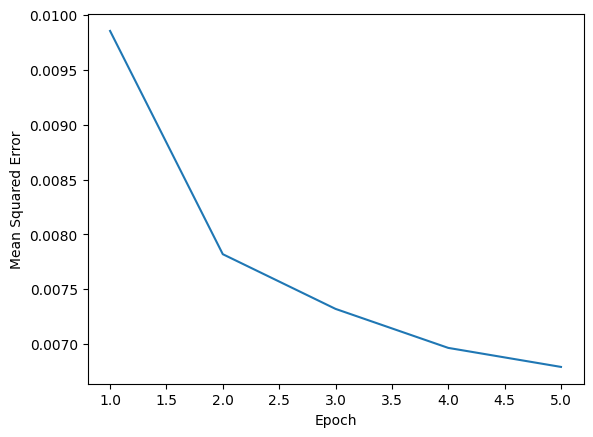

the trainind error is  0.006792884318033854


In [10]:
input_size = 28 * 28  # MNIST image size
hidden_size = 64  # Size of the hidden layer in the autoencoder
sparsity = 0.005  # Sparsity parameter for the autoencoder

# Initialize the Sparse Autoencoder
autoencoder = Sparse_Autoencoder(input_size, hidden_size, sparsity)

# Train the Sparse Autoencoder
learning_rate = 0.01
sparsity_weight = 0.01
max_epochs = 5
error = autoencoder.train(x_train.reshape(60000,28*28), learning_rate, sparsity_weight, max_epochs)
print("the trainind error is ",error)

In [11]:
error,x_pred = autoencoder.test(x_test[0:10].reshape(10,28*28))
print("the error on the test dataset is ",error)

the error on the test dataset is  tensor(0.0194, grad_fn=<DivBackward0>)


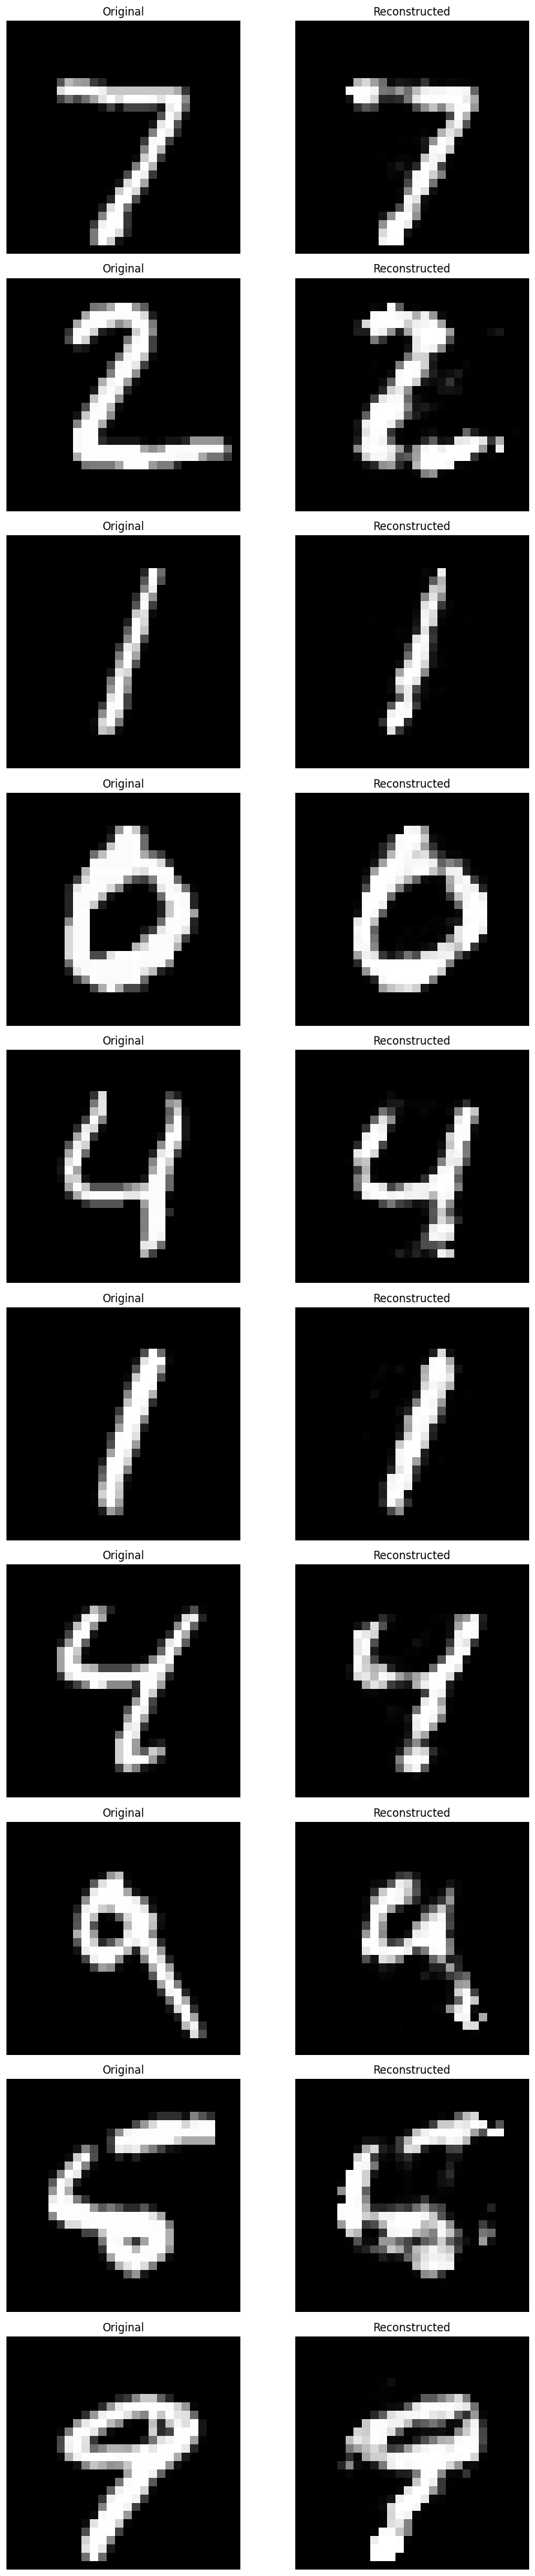

In [12]:
n = len(x_test[0:10])  # Number of images to plot

# Create a grid of subplots
fig, axs = plt.subplots(n, 2, figsize=(10, 4*n))

# Iterate over the images
for i in range(n):
    # Plot the original image
    axs[i, 0].imshow(x_test[i], cmap='gray')
    axs[i, 0].axis('off')
    axs[i, 0].set_title('Original')

    # Plot the reconstructed image
    axs[i, 1].imshow(x_pred[i].detach().numpy().reshape(28, 28), cmap='gray')
    axs[i, 1].axis('off')
    axs[i, 1].set_title('Reconstructed')

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()


<h4>Application and Comparison</h4>

<p>The Sparse Autoencoder is particularly useful in scenarios where the input data exhibits inherent sparsity or when a compact and informative representation is desired. One such application is the MNIST dataset, which consists of grayscale images of handwritten digits. Since the dataset naturally possesses sparsity due to the sparse distribution of ink in the images, the Sparse Autoencoder can effectively capture the essential features while reducing the dimensionality of the data.</p>

<p>Compared to other types of autoencoders, such as Denoising Autoencoders, the Sparse Autoencoder differs in its focus. While Denoising Autoencoders aim to learn robust features by training on corrupted versions of the input data, the Sparse Autoencoder emphasizes the enforcement of sparsity in the hidden layer activations. This constraint encourages the network to learn a more concise representation of the input, focusing on the most important features and disregarding irrelevant ones.</p>

<p>Overall, the Sparse Autoencoder provides a powerful approach to learn compact representations of input data while incorporating sparsity as a regularization constraint. By balancing the reconstruction loss and sparsity regularization, the model can capture essential features and promote efficient representations, making it suitable for various applications in data compression, feature learning, and anomaly detection.</p>